In [1]:
import os
import zarr
from glob import glob

import numpy as np
import xarray as xr
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
fn_area = '/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/static/C404_GP_grid_area.zarr'
ds_area = xr.open_zarr(fn_area)
area_da = ds_area['c404_area']

In [4]:
varname_verif = ['WRF_precip']

In [5]:
# get target
ds_collect = []
for year in range(2021, 2025):
    fn_pred = f'/glade/campaign/ral/hap/ksha/GWC_results/FINAL_run/target_{year}_WY_daily.zarr'
    ds_pred = xr.open_zarr(fn_pred)
    ds_pred = ds_pred[varname_verif].chunk(dict(time=-1))
    ds_collect.append(ds_pred)
    
ds_target = xr.concat(ds_collect, dim='time')

In [6]:
q_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 
            0.8, 0.85, 
            0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
            0.981, 0.982, 0.983, 0.984, 0.985, 0.986, 0.987, 0.988, 0.989, 0.99,]
tp_thres = [0.254, 2.54, 6.35, 12.7, 25.4]

dict_q = {}
ds_ETS_collect = []

for exp_name in ['B3H', 'B6H', 'GDAS',]:
    print(exp_name)
    
    ds_collect = []
    
    for year in range(2021, 2025):
        fn_pred = f'/glade/campaign/ral/hap/ksha/GWC_results/FINAL_run/final_{exp_name}_{year}_WY_daily.zarr'
        ds_pred = xr.open_zarr(fn_pred)
        ds_pred = ds_pred[varname_verif].chunk(dict(time=-1))
        ds_collect.append(ds_pred)
        
    ds_pred = xr.concat(ds_collect, dim='time')

    # ========================================== #
    # ETS
    obs = ds_target["WRF_precip"]
    fcst = ds_pred["WRF_precip"]
    obs, fcst = xr.align(obs, fcst)
    
    valid = np.isfinite(obs) & np.isfinite(fcst)
    obs = obs.where(valid)
    fcst = fcst.where(valid)
    
    # Define thresholds (mm/day)
    thresholds = xr.DataArray(
        tp_thres,
        dims="threshold",
        coords={"threshold": tp_thres},
        name="threshold"
    )
    
    # Boolean event occurrence (broadcast over threshold)
    obs_event  = obs >= thresholds   # dims: time, south_north, west_east, threshold
    fcst_event = fcst >= thresholds

    
    # =================================== #
    # CSI
    # window = 30
    # hits_day = (obs_event & fcst_event).sum(dim=("south_north", "west_east"))
    # misses_day = (obs_event & ~fcst_event).sum(dim=("south_north", "west_east"))
    # false_alarms_day = (~obs_event & fcst_event).sum(dim=("south_north", "west_east"))
    # hits_roll = hits_day.rolling(time=window, min_periods=window).sum()
    # misses_roll = misses_day.rolling(time=window, min_periods=window).sum()
    # false_alarms_roll = false_alarms_day.rolling(time=window, min_periods=window).sum()
    # csi = hits_roll / (hits_roll + misses_roll + false_alarms_roll)

    # =================================== #
    window = 30
    hits = (obs_event & fcst_event).sum(dim=("south_north", "west_east"))
    misses = (obs_event & ~fcst_event).sum(dim=("south_north", "west_east"))
    false_alarms = (~obs_event & fcst_event).sum(dim=("south_north", "west_east"))
    
    hits_win  = hits.rolling(time=window, min_periods=window).sum()
    misses_win = misses.rolling(time=window, min_periods=window).sum()
    false_alarms_win = false_alarms.rolling(time=window, min_periods=window).sum()
    n_samples_day = valid.sum(dim=("south_north", "west_east"))
    
    N_win = n_samples_day.rolling(time=window, min_periods=window).sum()
    N_win = N_win.broadcast_like(hits_win)  # add threshold dim
    
    # Random hits and ETS in the rolling window
    H_rand_win = ((hits_win + misses_win) * (hits_win + false_alarms_win) / N_win).where(N_win > 0)
    den_win = hits_win + misses_win + false_alarms_win - H_rand_win
    
    ets_win = (hits_win - H_rand_win) / den_win
    ets_win = ets_win.where(den_win != 0)  # dims: time, threshold
    ds_ETS_collect.append(ets_win.to_dataset(name=exp_name))

    # ========================================== #
    # quantile
    pred = ds_pred["WRF_precip"].chunk(dict(time=-1))
    pred_q = pred.quantile(q_levels, dim=("time", "south_north", "west_east"), skipna=True)
    dict_q[exp_name] = pred_q.values

ds_ETS_all = xr.merge(ds_ETS_collect)
ds_ETS_all = ds_ETS_all.chunk({'time': 1457, 'threshold': len(tp_thres)})
save_name = '/glade/campaign/ral/hap/ksha/GWC_results/scores/TP/ETS_all.zarr'
ds_ETS_all.to_zarr(save_name, mode='w')

obs = ds_target["WRF_precip"].chunk(dict(time=-1))
obs_q = obs.quantile(q_levels, dim=("time", "south_north", "west_east"), skipna=True)
dict_q['target'] = obs_q.values
save_name_np = '/glade/campaign/ral/hap/ksha/GWC_results/scores/TP/qq_all.npy'
np.save(save_name_np, dict_q)

B3H
B6H
GDAS


In [7]:
test = ets_win.values

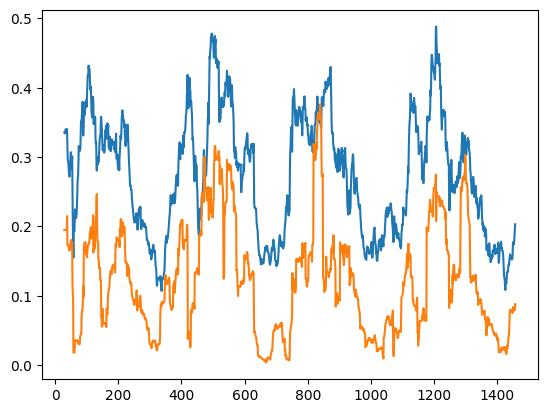

In [8]:
plt.plot(test[:, 0])
plt.plot(test[:, -1])

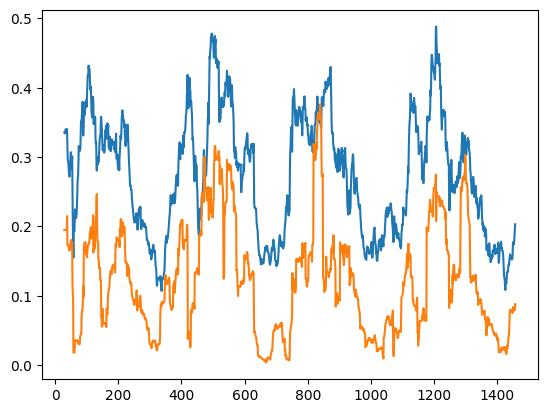

In [9]:
plt.plot(test[:, 0])
plt.plot(test[:, -1])